In [212]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [213]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [214]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [215]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [216]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [217]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [218]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [219]:
# Create our session (link) from Python to the DB
session = Session(engine)
first_row = session.query(measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f793bf718d0>,
 'station': 'USC00519397',
 'prcp': 0.08,
 'id': 1,
 'date': '2010-01-01',
 'tobs': 65.0}

# Exploratory Precipitation Analysis

In [220]:
# Find the most recent date in the data set.
most_recent = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(most_recent)

('2017-08-23',)


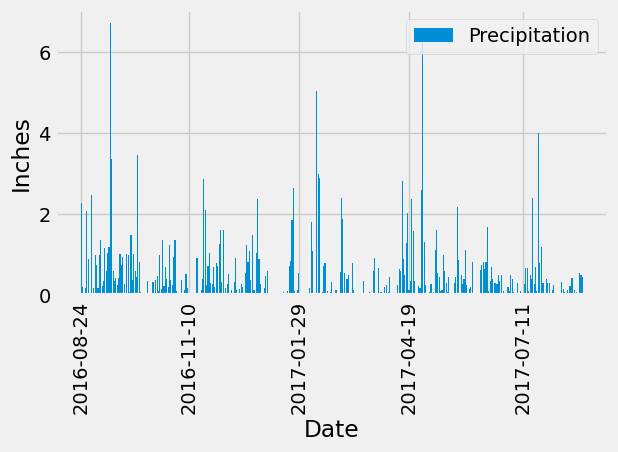

In [221]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
start_date = dt.datetime(2016,8,23)

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp).filter(measurement.date >= dt.datetime(2016,8,23)).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(results, columns=['date','precipitation'])

# Converted the date column to date time format
prcp_df['date'] = pd.to_datetime(prcp_df['date'])

# Sort the dataframe by date
sorted_prcp = prcp_df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.bar(sorted_prcp['date'], sorted_prcp['precipitation'], label='Precipitation')
xticks_labels = sorted_prcp['date'][::500].dt.strftime('%Y-%m-%d').tolist()
plt.xticks(sorted_prcp['date'][::500], xticks_labels, rotation='vertical')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend()
plt.tight_layout()
plt.show()

In [222]:
# Use Pandas to calculate the summary statistics for the precipitation data
sorted_prcp['precipitation'].describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [223]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(station.name).distinct().count()
station_count

9

In [224]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_counts = (
    session.query(measurement.station, func.count(measurement.station))
    .group_by(measurement.station)
    .order_by(desc(func.count(measurement.station)))
    .all())

for station, count in station_counts:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [225]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(measurement.tobs), 
       func.max(measurement.tobs), 
       func.avg(measurement.tobs)]
station_stats = session.query(*sel).filter(measurement.station == 'USC00519281').all()
print(station_stats)

[(54.0, 85.0, 71.66378066378067)]


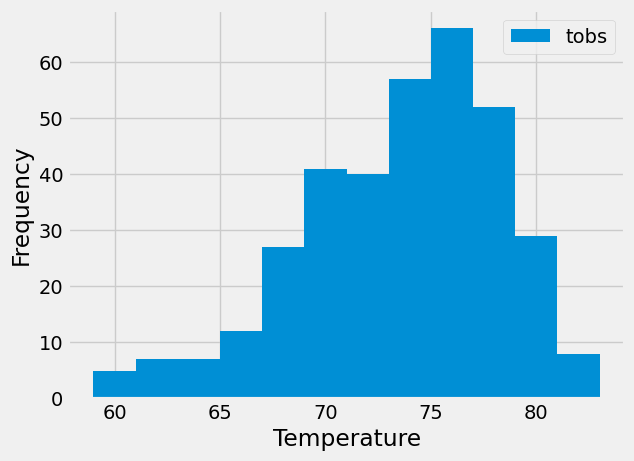

In [226]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperatures = (
    session.query(measurement.tobs)
    .filter(measurement.date >= dt.datetime(2016,8,23)).
    filter(measurement.station == 'USC00519281')
    .all())

temperatures = [temp[0] for temp in temperatures]

plt.hist(temperatures, bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()

# Close Session

In [227]:
# Close Session
session.close()